## FENG 2023

# Need to load these modules first in the env

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
set.seed(2422012)

# Single cell libraries
library(Seurat)
library(SoupX)
library(scater)
library(scDblFinder)
library(scran)
library(sctransform)
library(scry)

# Rest libraries
library(BiocParallel)
library(ggplot2)
library(dplyr)



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## Load Data

In [203]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/"
datadir = projectdir + "Data/"
resultdir = projectdir + "Result/"
# csv_list = os.listdir(datadir)

csv_list = [i for i in os.listdir(datadir) if i[0] != "."] 

iteration = 7
file = csv_list[iteration]
splitted_name = csv_list[iteration].split("_")
Condition = splitted_name[2]
CellType = splitted_name[3][:-4]

In [204]:
# Filtering Parameters
min_genes_per_cell = 100 # To keep cells with more than X genes
min_cells_per_gene = 10 # To keep genes expressed in more than X cells

# Mitochondrial counts percentage filtering
mito_cut_per = 10 #

# Remove genesets
remove_mitochondrial = True
remove_ribosomal     = True
remove_mitocard      = True
remove_noncoding     = True

In [205]:
csv_list[0]

'counts_filtered_HC_CCR7mCD45ROm.csv'

In [206]:
DEM = pd.read_csv(datadir+file,index_col=0).T
adata = sc.AnnData(DEM,dtype=np.float32)
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

In [207]:
adata

AnnData object with n_obs × n_vars = 3855 × 17519
    obs: 'n_genes'
    var: 'n_cells'

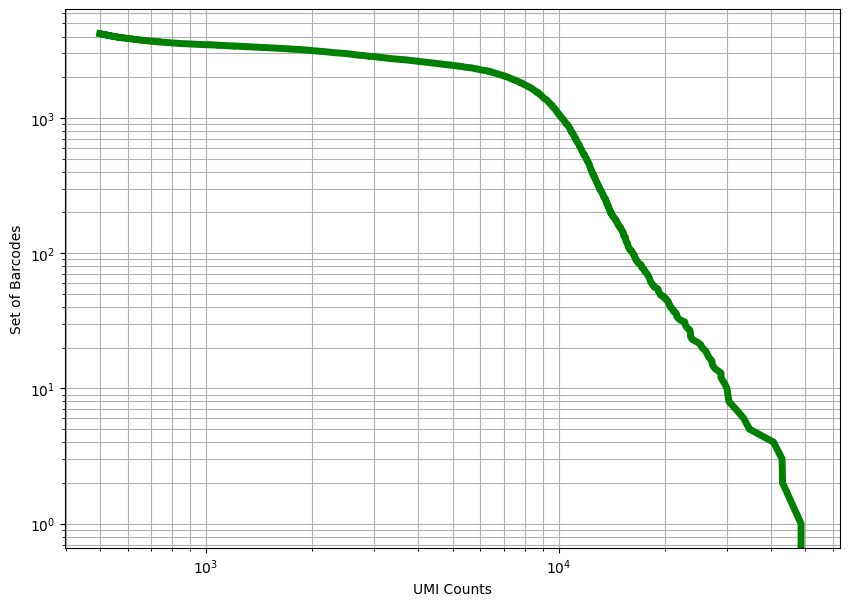

In [208]:
# Create the "knee plot"
knee = np.sort((np.array(DEM.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)),linewidth=5, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [209]:
# Normalization
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [210]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [211]:
# Free memory
del adata_pp

In [212]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T
data.shape

(17519, 3855)

In [213]:
# Filter
adata_raw = sc.AnnData(DEM,dtype=np.float32)
adata_raw.var_names_make_unique()
sc.pp.filter_cells(adata_raw, min_genes=min_genes_per_cell)
sc.pp.filter_genes(adata_raw, min_cells=min_cells_per_gene)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
del adata_raw

In [214]:
%%R -i data -i genes -i cells -i data_tod 
# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

In [215]:
%%R -i soupx_groups -o out 
# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

In [216]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

## Doublet Detection

In [217]:
data_mat = adata.X.T

In [218]:
%%R -i data_mat -o droplet_class
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
droplet_class = sce$scDblFinder.class
droplet_class <- as.vector(droplet_class)
droplet_class[droplet_class==1] <- 'singlet'
droplet_class[droplet_class==2] <- 'doublet'

In [219]:
adata.obs["scDblFinder_class"] = droplet_class
adata.obs.scDblFinder_class.value_counts()

singlet    3559
doublet     296
Name: scDblFinder_class, dtype: int64

In [220]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[adata.obs.scDblFinder_class == "singlet"].copy()
print(f"Number of cells after filtering of doublets: {adata.n_obs}")

Total number of cells: 3855
Number of cells after filtering of doublets: 3559


In [221]:
sc.pp.calculate_qc_metrics(
    adata, inplace=True, percent_top=[20], log1p=True
)

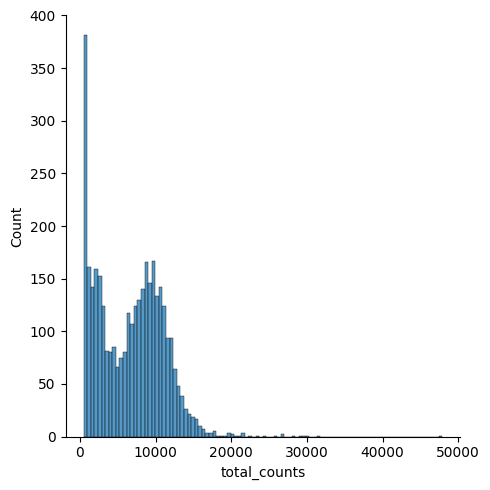

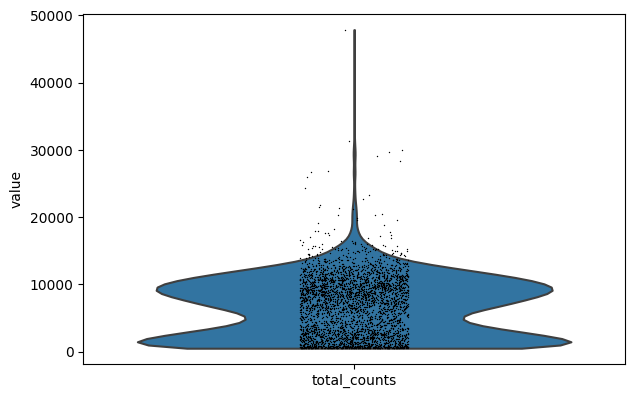

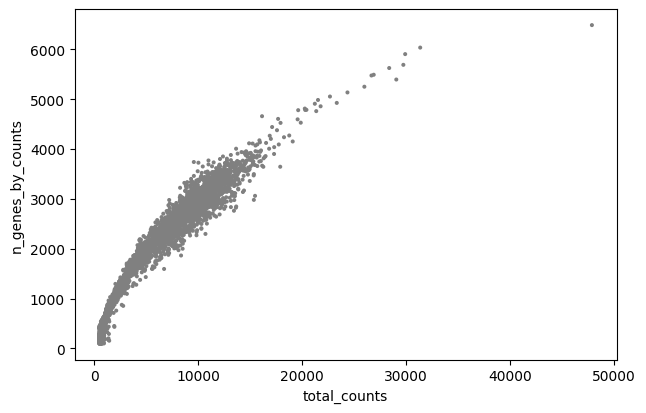

In [222]:
import seaborn as sns
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, 'total_counts')
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

In [223]:
print(f"Total number of genes: {adata.n_vars}")
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 17519
Number of genes after cell filter: 14840


## Normalization

In [224]:
# proportional fitting to mean of cell depth
proportional_fitting = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1pPF_normalization"] = sc.pp.log1p(proportional_fitting["X"])
# proportional fitting
adata.layers["PFlog1pPF_normalization"] = sc.pp.normalize_total(
    adata, target_sum=None, layer="log1pPF_normalization", inplace=False
)["X"]

## Dimensionality Reduction

In [225]:
adata.X = adata.layers["log1pPF_normalization"]
sc.pp.pca(adata, n_comps=30, use_highly_variable=False, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30)

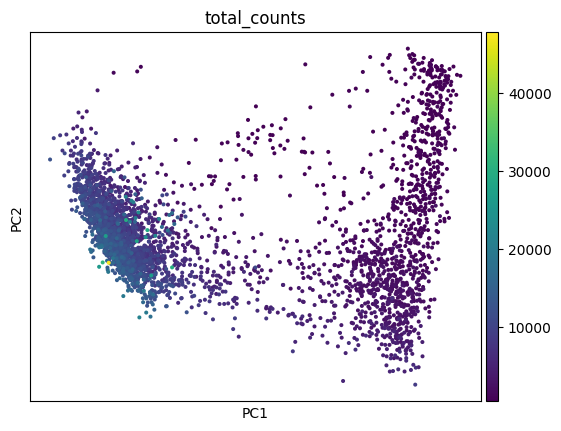

In [226]:
sc.pl.pca_scatter(adata, color="total_counts")

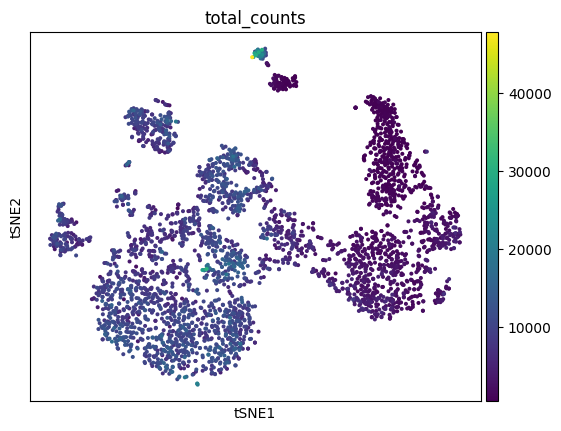

In [227]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color="total_counts")

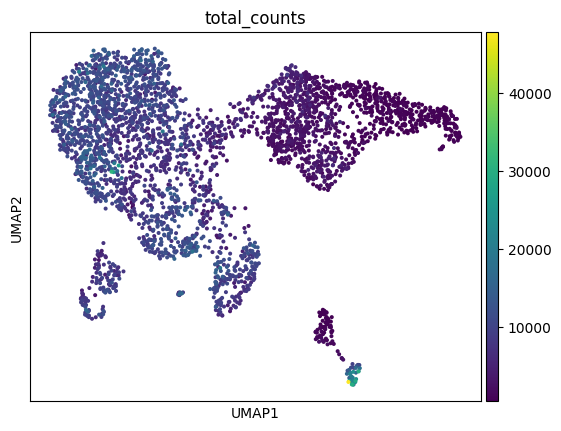

In [228]:
sc.tl.umap(adata)
sc.pl.umap(adata, color="total_counts")

In [229]:

adata.obs["Condition"] = Condition 
adata.obs["CellType"] = CellType

In [230]:
adata.write(resultdir+Condition+"_"+CellType+"_preprocessed.h5ad")

In [ ]:



sc.pl.umap(adata, color = ['louvain','CCR7','PTPRC'])
